# Paper Figure 3: Feature Finder

This notebook uses GPU, so please run in an environment with CUDA installed.


In [1]:
import os
from test_files import get_files, prepare_test

files = ['thermo_HeLa.raw']

In [2]:
!nvidia-smi

Wed Jul 19 12:37:20 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.25                 Driver Version: 536.25       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti   WDDM  | 00000000:65:00.0 Off |                  N/A |
| 30%   32C    P8              24W / 250W |    528MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import cupy
print(cupy.__version__)

8.3.0


In [4]:
tmp_folder = 'F:/projects/alphapept/sandbox/temp'
test_folder = 'fig3'

get_files(tmp_folder, files)
prepare_test(files, tmp_folder, test_folder)

Creating dir F:/projects/alphapept/sandbox/temp\fig3.


## Convert raw file

In [5]:
import alphapept.settings
import alphapept.paths
import alphapept.interface

test_folder = os.path.join(tmp_folder, test_folder)

file_name = os.path.join(test_folder, files[0])
settings = alphapept.settings.load_settings(alphapept.paths.DEFAULT_SETTINGS_PATH)
settings['experiment']['file_paths'] = [file_name]
settings_ = alphapept.interface.import_raw_data(settings)
base, ext = os.path.splitext(file_name)

2023-07-19 12:37:30> Logging to C:\Users\admin\alphapept\logs\log_20230719123730.txt.
2023-07-19 12:37:30> Code location f:\projects\alphapept\alphapept
2023-07-19 12:37:30> Python location C:\ProgramData\Miniconda3\envs\alphapept\python.exe
2023-07-19 12:37:30> Platform information:
2023-07-19 12:37:30> system     - Windows
2023-07-19 12:37:30> release    - 10
2023-07-19 12:37:30> version    - 10.0.19044
2023-07-19 12:37:30> machine    - AMD64
2023-07-19 12:37:30> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2023-07-19 12:37:30> cpu count  - 24
2023-07-19 12:37:30> ram memory - 118.4/127.7 Gb (available/total)
2023-07-19 12:37:30> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2023-07-19 12:37:30> Python information:
2023-07-19 12:37:30> SQLAlchemy                    - 1.4.39
2023-07-19 12:37:30> alphapept                     - 0.5.0
2023-07-19 12:37:30> alpharaw                      - 0.1.0
2023-07-19 12:37:30> alphatims                     - 1.0.7

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2023-07-19 12:37:30> Processing 1 files for step raw_conversion
2023-07-19 12:37:30> File F:/projects/alphapept/sandbox/temp\fig3\thermo_HeLa has extension .raw - converting from Thermo.
2023-07-19 12:39:33> File conversion complete. Extracted 120,226 precursors.
2023-07-19 12:39:35> File conversion of file F:/projects/alphapept/sandbox/temp\fig3\thermo_HeLa.raw complete.


  0%|                                                                                            | 0/1 [02:05<?, ?it/s]


## Prepare settings for Feature Finder

In [6]:
import numpy as np

ms_file = alphapept.io.MS_Data_File(f"{base}.ms_data.hdf", is_read_only=True)
query_data = ms_file.read_DDA_query_data()
int_data = np.array(query_data['int_list_ms1'])

f_settings = settings['features']
max_gap = f_settings['max_gap']
centroid_tol = f_settings['centroid_tol']
hill_split_level = f_settings['hill_split_level']
hill_smoothing = f_settings['hill_smoothing']
hill_check_large = f_settings['hill_check_large']

iso_charge_min = f_settings['iso_charge_min']
iso_charge_max = f_settings['iso_charge_max']
iso_n_seeds = f_settings['iso_n_seeds']

hill_nboot_max = f_settings['hill_nboot_max']
hill_nboot = f_settings['hill_nboot']
iso_mass_range = f_settings['iso_mass_range']

iso_corr_min = f_settings['iso_corr_min']

In [7]:
import timeit
import time
import alphapept.performance
import alphapept.feature_finding
import importlib
import logging

def timing_decorator(func, timings_dict, repeats=3, loops_per_repeat=1):
    def wrapper(*args, **kwargs):
        if func.__name__ not in timings_dict:
            timings_dict[func.__name__] = {}
        if alphapept.performance.COMPILATION_MODE in timings_dict[func.__name__]:
            logging.warning(
                f"{func.__name__} is already timed for {alphapept.performance.COMPILATION_MODE}"
            )
        start = time.time()
        results = func(*args, **kwargs)
        timings_dict[func.__name__][alphapept.performance.COMPILATION_MODE] = time.time() - start
        return results
    return wrapper

In [8]:
def time_feature_finding_functions(
    compilation_mode,
    timings_dict,
    repeats=3,
    loops_per_repeat=1
):
    print(f"Running feature finding functions with compilation mode '{compilation_mode}'")
    alphapept.performance.set_compilation_mode(compilation_mode)
    importlib.reload(alphapept.feature_finding)
    alphapept.feature_finding.connect_centroids_unidirection = timing_decorator(
        alphapept.feature_finding.connect_centroids_unidirection,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.convert_connections_to_array = timing_decorator(
        alphapept.feature_finding.convert_connections_to_array,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.eliminate_overarching_vertex = timing_decorator(
        alphapept.feature_finding.eliminate_overarching_vertex,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.path_finder = timing_decorator(
        alphapept.feature_finding.path_finder,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.find_path_start = timing_decorator(
        alphapept.feature_finding.find_path_start,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.find_path_length = timing_decorator(
        alphapept.feature_finding.find_path_length,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
    alphapept.feature_finding.fill_path_matrix = timing_decorator(
        alphapept.feature_finding.fill_path_matrix,
        timings_dict,
        repeats=3,
        loops_per_repeat=1
    )
        
    logging.info(f'Hill extraction with centroid_tol {centroid_tol} and max_gap {max_gap}')
    hill_ptrs, hill_data, path_node_cnt, score_median, score_std = alphapept.feature_finding.extract_hills(query_data, max_gap, centroid_tol)
    logging.info(f'Number of hills {len(hill_ptrs):,}, len = {np.mean(path_node_cnt):.2f}')

In [9]:
timings_dict = {}

modes = ["cuda", "numba-multithread", "numba", "python"]

for mode in modes:
    time_feature_finding_functions(mode, timings_dict)

Running feature finding functions with compilation mode 'cuda'
2023-07-19 12:39:38> Hill extraction with centroid_tol 8 and max_gap 2
2023-07-19 12:39:49> Number of hills 1,105,353, len = 17.35
Running feature finding functions with compilation mode 'numba-multithread'
2023-07-19 12:39:49> Hill extraction with centroid_tol 8 and max_gap 2
2023-07-19 12:39:57> Number of hills 1,105,353, len = 17.35
Running feature finding functions with compilation mode 'numba'
2023-07-19 12:39:57> Hill extraction with centroid_tol 8 and max_gap 2
2023-07-19 12:40:05> Number of hills 1,105,353, len = 17.35
Running feature finding functions with compilation mode 'python'
2023-07-19 12:40:05> Hill extraction with centroid_tol 8 and max_gap 2
2023-07-19 12:44:23> Number of hills 1,105,353, len = 17.35


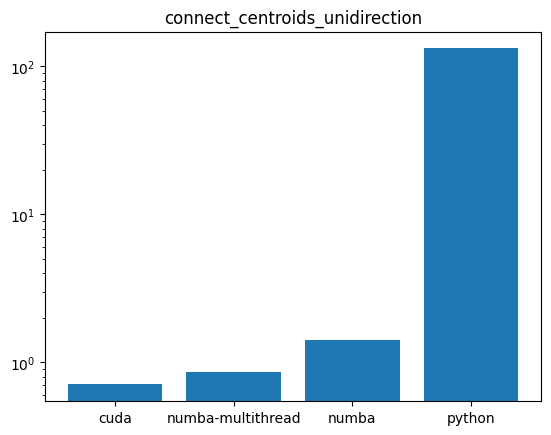

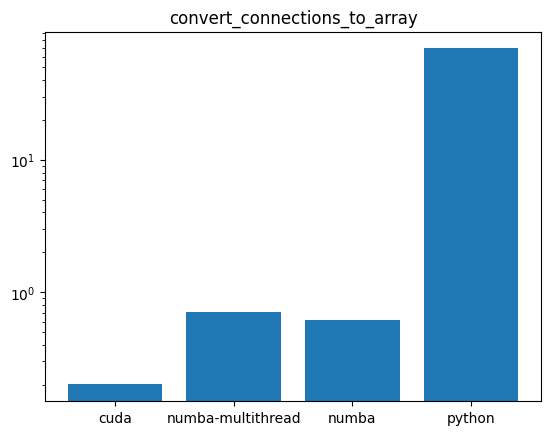

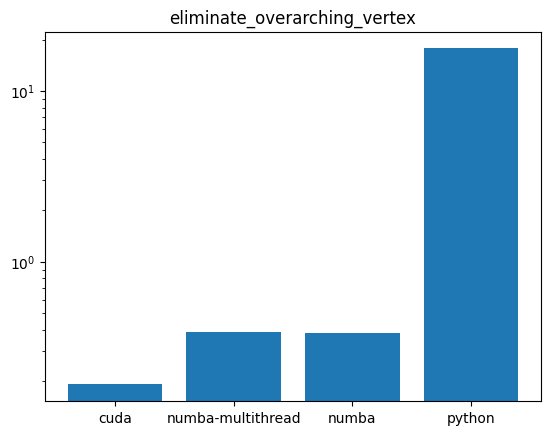

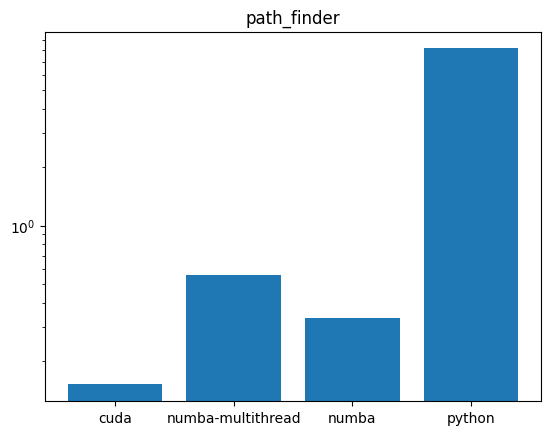

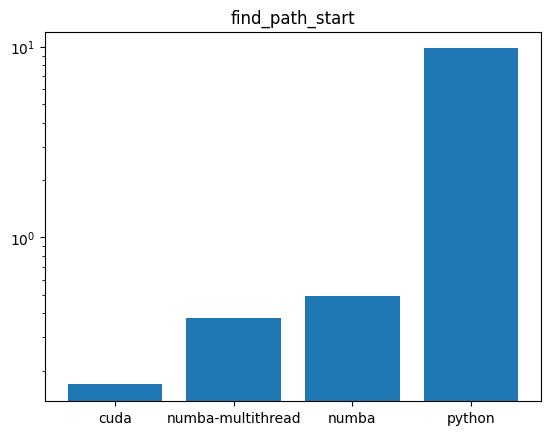

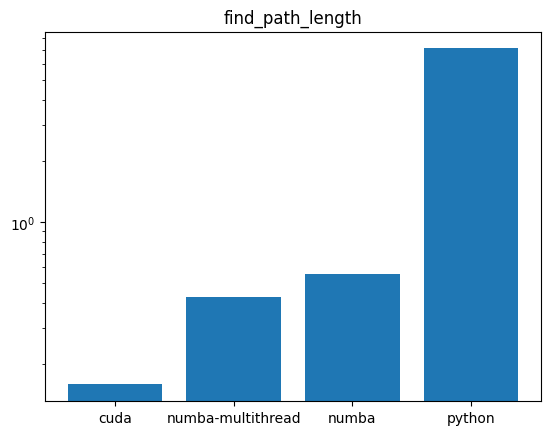

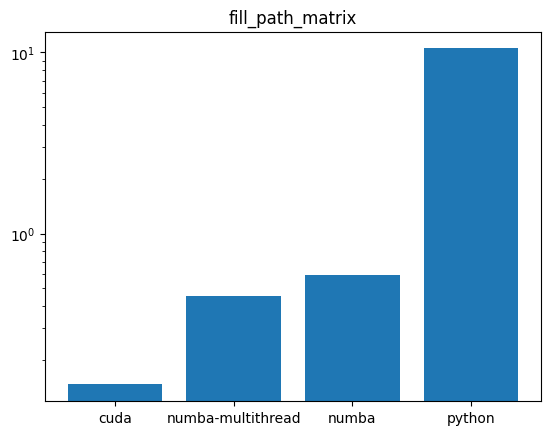

In [10]:
from matplotlib import pyplot as plt
include_python = True
for func in timings_dict:
    if not include_python:
        plt.bar(list(timings_dict[func].keys())[:-1], list(timings_dict[func].values())[:-1])
    else:
        plt.bar(list(timings_dict[func].keys()), list(timings_dict[func].values()))
    plt.yscale('log')
    plt.title(func)
    plt.show()

## Get summary timing

In [11]:
timings_dict

{'connect_centroids_unidirection': {'cuda': 0.7070827484130859,
  'numba-multithread': 0.860755205154419,
  'numba': 1.4164535999298096,
  'python': 132.29240584373474},
 'convert_connections_to_array': {'cuda': 0.20070981979370117,
  'numba-multithread': 0.7131309509277344,
  'numba': 0.614556074142456,
  'python': 69.33917951583862},
 'eliminate_overarching_vertex': {'cuda': 0.19120383262634277,
  'numba-multithread': 0.3858914375305176,
  'numba': 0.3841571807861328,
  'python': 17.740697860717773},
 'path_finder': {'cuda': 0.15186858177185059,
  'numba-multithread': 0.5535426139831543,
  'numba': 0.33284878730773926,
  'python': 8.172771215438843},
 'find_path_start': {'cuda': 0.16934704780578613,
  'numba-multithread': 0.3789186477661133,
  'numba': 0.49212074279785156,
  'python': 9.808532953262329},
 'find_path_length': {'cuda': 0.15913009643554688,
  'numba-multithread': 0.4283106327056885,
  'numba': 0.5532937049865723,
  'python': 7.1435770988464355},
 'fill_path_matrix': {'c

In [14]:
timings_dict = {'connect_centroids_unidirection': {'cuda': 0.7070827484130859,
  'numba-multithread': 0.860755205154419,
  'numba': 1.4164535999298096,
  'python': 132.29240584373474},
 'convert_connections_to_array': {'cuda': 0.20070981979370117,
  'numba-multithread': 0.7131309509277344,
  'numba': 0.614556074142456,
  'python': 69.33917951583862},
 'eliminate_overarching_vertex': {'cuda': 0.19120383262634277,
  'numba-multithread': 0.3858914375305176,
  'numba': 0.3841571807861328,
  'python': 17.740697860717773},
 'path_finder': {'cuda': 0.15186858177185059,
  'numba-multithread': 0.5535426139831543,
  'numba': 0.33284878730773926,
  'python': 8.172771215438843},
 'find_path_start': {'cuda': 0.16934704780578613,
  'numba-multithread': 0.3789186477661133,
  'numba': 0.49212074279785156,
  'python': 9.808532953262329},
 'find_path_length': {'cuda': 0.15913009643554688,
  'numba-multithread': 0.4283106327056885,
  'numba': 0.5532937049865723,
  'python': 7.1435770988464355},
 'fill_path_matrix': {'cuda': 0.1472005844116211,
  'numba-multithread': 0.45360374450683594,
  'numba': 0.5939939022064209,
  'python': 10.520855903625488}}

C:\Users\admin\AppData\Local\Temp\ipykernel_7436\3430560407.py:34: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 1500])


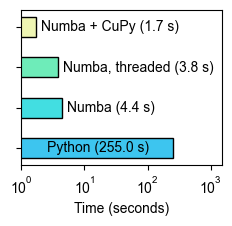

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

dark_blue = '#17212b'
light_blue = '#3dc5ef'
teal= '#42dee1'
green = '#6eecb9'
yellow = '#eef5b3'

colors = [light_blue, teal, green, yellow]
data = pd.DataFrame.from_dict(timings_dict).sum(axis=1).iloc[::-1]

hfont = {'fontname':'Arial', 'size':10}
plt.figure(figsize=(2.363,2.363)) #60x60

height=0.5

text = [f'Python ({data.python:.1f} s)', f"Numba ({data.numba:.1f} s)", f"Numba, threaded ({data['numba-multithread']:.1f} s)", f"Numba + CuPy ({data.cuda:.1f} s)"]


for i in range(len(data)): 
    t = data[i]
    plt.barh(i, t, height, color = colors[i], linewidth=1, edgecolor='black')
    if i == 0:
        plt.text(t/100, i, text[i], **hfont, va='center')
    else:
        plt.text(t*1.2, i, text[i], **hfont, va='center')
        
plt.yticks(range(len(data)), data.index, **hfont)
plt.xticks(**hfont)

plt.xscale('log')
plt.xlim([0, 1500])
plt.xlabel('Time (seconds)', **hfont)
ax = plt.gca()
ax.set_yticklabels([])
plt.tight_layout()
plt.xticks([1e0, 1e1, 1e2 , 1e3])

plt.savefig('./figures/03_ff.pdf')  
plt.show()